In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

Обработка набора данных

In [2]:
ds = pd.read_csv("../data/Smoker_dataset.csv")

ds = ds.rename(columns = {"type" : "Is smoker?", "Condition" : "Has cancer?"})

ds = ds.dropna()

ds["Has cancer?"] = [1 if elem == "Cancer" else 0 for elem in ds["Has cancer?"]]

genes = ["Gene2337", "Gene35715", "Gene12936", "Gene1689", "FGFR1", "GATA4"]
GOOD = 10.0

for gene in genes:
    ds = ds.loc[abs(ds[gene]) <= GOOD]

Примененяю One-Hot Encoding к категориальному признаку

In [3]:
ds = pd.get_dummies(ds)
ds.head()

,Gene2337,Gene35715,Gene12936,Gene1689,FGFR1,GATA4,Has cancer?,Is smoker?_Nonsmoker,Is smoker?_Smoker
0,-4.750470,-1.518091,6.715013,-1.722331,0.170110,-7.846961,1,0,1
1,-5.183375,0.039654,2.529460,-1.323490,-0.315844,-4.447406,1,0,1
2,1.579079,1.588153,0.569724,-1.229601,-4.119116,0.649277,0,0,1
3,-1.557053,-3.818996,3.798518,-1.204911,1.010464,-6.712354,1,0,1
4,-1.329637,-3.623963,2.722249,-0.784387,1.564218,-5.580853,1,0,1


Разбиваю на признаки и классы

In [4]:
X = ds.drop("Has cancer?", axis = 1).to_numpy()
y = ds["Has cancer?"].to_numpy()

print(X.shape)
print(y.shape)

(1000, 8)
(1000,)


In [5]:
X[:5]

array([[-4.75047047, -1.51809118,  6.71501286, -1.72233072,  0.17011048,
        -7.84696068,  0.        ,  1.        ],
       [-5.18337517,  0.03965445,  2.52946043, -1.32348957, -0.31584364,
        -4.44740644,  0.        ,  1.        ],
       [ 1.57907908,  1.5881532 ,  0.56972429, -1.22960145, -4.11911617,
         0.64927698,  0.        ,  1.        ],
       [-1.55705255, -3.81899603,  3.79851766, -1.20491135,  1.01046375,
        -6.71235373,  0.        ,  1.        ],
       [-1.32963731, -3.6239626 ,  2.72224926, -0.78438661,  1.56421809,
        -5.58085274,  0.        ,  1.        ]])

Нормализую все признаки, чтобы они были в промежутке $[-1, 1]$

In [6]:
from sklearn.preprocessing import normalize
X = normalize(X, norm = "max", axis = 0)

In [7]:
X[:5]

array([[-0.53243755, -0.20069442,  0.94794783, -0.22613268,  0.02647339,
        -0.96918971,  0.        ,  1.        ],
       [-0.58095794,  0.00524239,  0.35707996, -0.173767  , -0.04915306,
        -0.54930574,  0.        ,  1.        ],
       [ 0.17698478,  0.20995675,  0.08042708, -0.16144   , -0.64103609,
         0.08019316,  0.        ,  1.        ],
       [-0.17451603, -0.50487823,  0.53623078, -0.15819832,  0.15725309,
        -0.82905273,  0.        ,  1.        ],
       [-0.1490271 , -0.47909445,  0.38429566, -0.10298571,  0.24343092,
        -0.68929937,  0.        ,  1.        ]])

Разбиваю на обучающую и тестовую выборку

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(800, 8)
(800,)
(200, 8)
(200,)


Функция, которая выводит Accuracy, Recall и Precision, рисует Confusion Matrix и ROC-кривую
* Accuracy - число верно угаданных
* Recall - полнота
* Precision - точность

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay

def scores(model, X, y_true):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    figure = plt.figure(figsize = (20, 5))
    matr = confusion_matrix(y_true, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y_true, y_pred = y_pred, name = "ROC-кривая", ax = ax)
    plt.show()

Функция, которая печатает результат подбора гиперпараметров модели

In [10]:
def best(model):
    print("Лучшие гиперпараметры модели:", model.best_params_)
    print("Лучший счёт модели:", model.best_score_)

Использую [этот шаблон](https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/_template.py) для реализации классификаторов

## Дерево принятия решений

Хранение данных в вершине дерева. Хранится предикат $X_{ind} \ge value$, если вершина не лист, иначе класс $value$

In [11]:
class TreeData():
    def __init__(self, value = None, ind = None, leaf = True):
        self.value = value
        self.ind = ind
        self.leaf = leaf
    
    def is_leaf(self):
        return self.leaf
    
    def decide(self, X):
        if (self.is_leaf()):
            return None
        else:
            return True if (X[self.ind] >= self.value) else False
    
    def predict(self, X):
        if (self.is_leaf()):
            return value
        else:
            return None

Класс для хранения дерева. Реализован как список смежности

In [12]:
class Graph:
    def __init__(self):
        self.data = []
        self.info = []
        self.size = 0
        self.add()
    
    def can_go(self, u, c):
        return c in self.data[u]
    
    def go(self, u, c):
        return self.data[u][c]
    
    def set_go(self, u, c, v):
        self.data[u][c] = v

    def get_tree_data(self, u):
        return self.info[u]
    
    def set_tree_data(self, u, tree_data):
        self.info[u] = tree_data
    
    def add(self):
        self.data.append(dict())
        self.info.append(TreeData())
        self.size += 1
        return self.size - 1

    def is_leaf(self, u):
        return self.info[u].is_leaf()

Решающее дерево

In [13]:
class DecisionTree:
    def __init__(self, max_depth, min_count, rnd_split):
        self.tree = Graph()
        self.max_depth = max_depth
        self.min_count = min_count
        self.rnd_split = rnd_split
        self.data = []
    
    # Подсчитывает количество 0 и 1
    def get_count(self, arr):
        res = [0 for _ in range(2)]
        for elem in arr:
            res[elem] += 1
        return res
    
    def ans(self, cnt0, cnt1):
        if (cnt0 + cnt1 == 0):
            return None
        else:
            return (cnt1) / (cnt0 + cnt1)
    
    def ans_class(self, p):
        return 1 if (p > 0.5) else 0
        
    def decide(self, X):
        return self.decide_rec(0, X)
    
    def decide_rec(self, u, X):
        u_data = self.tree.get_tree_data(u)
        if (self.tree.is_leaf(u)):
            return u_data.value
        else:
            dec = u_data.decide(X)
            return self.decide_rec(self.tree.go(u, dec), X)
    
    def make_leaf(self, u, value):
        u_data = TreeData(value = value, leaf = True)
        self.tree.set_tree_data(u, u_data)
    
    # Генерирует случайные индексы без повторений
    def rnd_ids(self, n):
        res = []
        while (len(res) * len(res) < n):
            rnd_num = randint(0, n - 1)
            while (rnd_num in res):
                rnd_num = randint(0, n - 1)
            res.append(rnd_num)
        return res
    
    def build(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.d = X.shape[1]
        ids = np.arange(self.n)
        self.build_rec(0, ids, 1)
    
    def build_rec(self, u, ids, h):
        X = self.X[ids]
        y = self.y[ids]
        u_cnt = self.get_count(y)
        u_ans = self.ans(u_cnt[0], u_cnt[1])
        stop1 = (len(y) <= self.min_count)
        stop2 = (h > self.max_depth)
        stop3 = (u_ans == None)
        if (stop1 or stop2 or stop3):
            self.make_leaf(u, u_ans)
            return
        z = self.ans_class(u_ans)
        n = len(ids)
        min_loss = n - u_cnt[z]
        res = (-1, -1)
        u_data = self.tree.get_tree_data(u)
        split_ids = (self.rnd_ids(self.d) if self.rnd_split else range(self.d))
        for i in split_ids:
            cnt_l, cnt_r = [0 for _ in range(2)], [elem for elem in u_cnt]
            tmp = sorted([(elem[i], y[j]) for (j, elem) in enumerate(X)])
            loss_l, loss_r = 0, n - u_cnt[z]
            size_l, size_r = 0, n
            for j in range(self.n):
                while (size_l < n and tmp[size_l][0] <= tmp[j][0]):
                    y_l = tmp[size_l][1]
                    cnt_l[y_l] += 1
                    cnt_r[y_l] -= 1
                    size_l += 1
                    size_r -= 1
                if (size_l == 0 or size_r == 0):
                    continue
                ans_l = self.ans_class(self.ans(cnt_l[0], cnt_l[1]))
                ans_r = self.ans_class(self.ans(cnt_r[0], cnt_r[1]))
                loss_l = size_l - cnt_l[ans_l]
                loss_r = size_r - cnt_r[ans_r]
                split_loss = loss_l + loss_r
                if (split_loss < min_loss):
                    min_loss = split_loss
                    res = (i, tmp[j][0])
        if (res == (-1, -1)):
            self.make_leaf(u, u_ans)
            return
        u_data = TreeData(value = res[1], ind = res[0], leaf = False)
        self.tree.set_tree_data(u, u_data)
        l, r = [], []
        for (j, elem) in enumerate(X):
            if (u_data.decide(elem)):
                l.append(j)
            else:
                r.append(j)
        l, r = np.array(l), np.array(r)
        if (len(l) == 0 or len(r) == 0):
            self.make_leaf(u, u_ans)
            return
        ul = self.tree.add()
        ur = self.tree.add()
        self.tree.set_go(u, True, ul)
        self.tree.set_go(u, False, ur)
        self.build_rec(ul, l, h + 1)
        self.build_rec(ur, r, h + 1)

Классификатор

In [14]:
class MyDecisionTreeClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, max_depth = 10, min_count = 50, rnd_split = False):
        self.max_depth = max_depth
        self.min_count = min_count
        self.rnd_split = rnd_split
        self.tree = DecisionTree(max_depth, min_count, rnd_split)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.tree.build(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        p = []
        for elem in X:
            z = self.tree.decide(elem)
            p.append(1 if z > 0.5 else 0)
        return np.array(p)

In [15]:
gscv1 = GridSearchCV(Pipeline([("dtc", MyDecisionTreeClassifier())]),
                    {"dtc__max_depth" : [1, 2, 4, 8],
                     "dtc__min_count" : [1, 2, 5, 10, 25, 50]})
gscv1.fit(train_X, train_y)
best(gscv1)

Лучшие гиперпараметры модели: {'dtc__max_depth': 1, 'dtc__min_count': 1}
Лучший счёт модели: 0.9875


Accuracy: 0.985
Recall: 0.9726027397260274
Precision: 0.9861111111111112


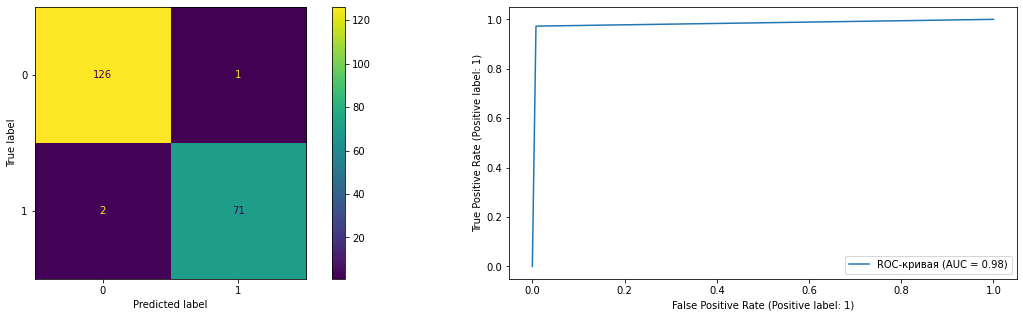

In [16]:
DTC_best_my = gscv1.best_estimator_
scores(DTC_best_my, test_X, test_y)

In [17]:
f = open("DTC.pkl", "wb")
pickle.dump(DTC_best_my, f, pickle.HIGHEST_PROTOCOL)
f.close()

[Decision Tree Classifier](sklearn.tree.DecisionTreeClassifier) из библиотеки scikit-learn

In [18]:
from sklearn.tree import DecisionTreeClassifier

gscv2 = GridSearchCV(Pipeline([("dct", DecisionTreeClassifier())]),
                    {"dct__criterion" : ["gini", "entropy", "log_loss"],
                     "dct__splitter" : ["best", "random"],
                     "dct__max_depth" : [1, 2, 4, 8]})
gscv2.fit(train_X, train_y)
best(gscv2)

Лучшие гиперпараметры модели: {'dct__criterion': 'entropy', 'dct__max_depth': 8, 'dct__splitter': 'random'}
Лучший счёт модели: 0.9925


Accuracy: 0.98
Recall: 0.9726027397260274
Precision: 0.9726027397260274


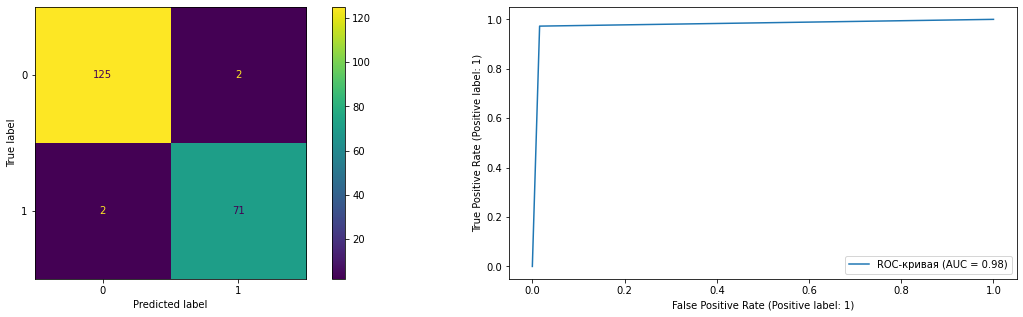

In [19]:
DTC_best = gscv2.best_estimator_
scores(DTC_best, test_X, test_y)

## Случайный лес

Классификатор содержит список решающих деревьев

In [20]:
class MyRandomForestClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, n_trees = 10, max_depth = 2, min_count = 5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_count = min_count
        self.trees = [DecisionTree(max_depth, min_count, rnd_split = True) for _ in range(self.n_trees)]

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for (i, tree) in enumerate(self.trees):
            rnd_ids = np.random.choice(len(X), (2 * len(X)) // self.n_trees)
            X_sub = X[rnd_ids]
            y_sub = y[rnd_ids]
            tree.build(X_sub, y_sub)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        p = []
        for elem in X:
            z = 0
            for tree in self.trees:
                z += tree.decide(elem)
            z /= self.n_trees
            p.append(1 if z > 0.5 else 0)
        return np.array(p)

In [21]:
gscv3 = GridSearchCV(Pipeline([("rfc", MyRandomForestClassifier())]),
                    {"rfc__n_trees" : [25, 50, 100],
                     "rfc__max_depth" : [1, 2, 4],
                     "rfc__min_count" : [10, 25, 50]})
gscv3.fit(train_X, train_y)
best(gscv3)

Лучшие гиперпараметры модели: {'rfc__max_depth': 1, 'rfc__min_count': 10, 'rfc__n_trees': 25}
Лучший счёт модели: 0.5912499999999999


Accuracy: 0.985
Recall: 0.9726027397260274
Precision: 0.9861111111111112


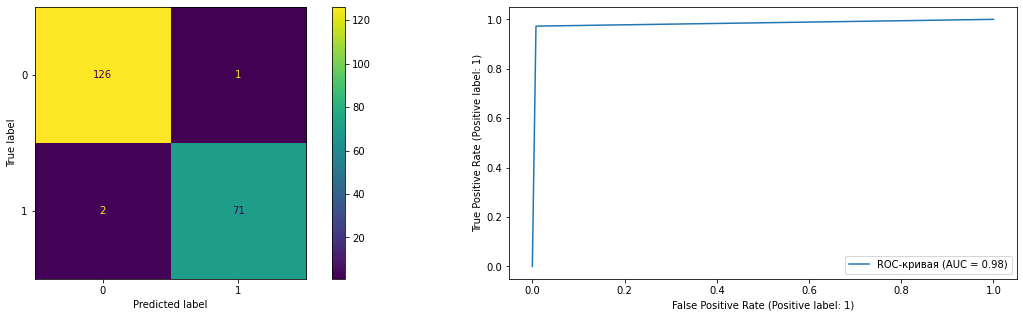

In [22]:
RFC_best_my = gscv3.best_estimator_
scores(RFC_best_my, test_X, test_y)

In [23]:
f = open("RFC.pkl", "wb")
pickle.dump(RFC_best_my, f, pickle.HIGHEST_PROTOCOL)
f.close()

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из библиотеки scikit-learn

In [24]:
from sklearn.ensemble import RandomForestClassifier

gscv4 = GridSearchCV(Pipeline([("dct", RandomForestClassifier())]),
                    {"dct__n_estimators" : [25, 50, 100],
                     "dct__criterion" : ["gini", "entropy", "log_loss"],
                     "dct__max_depth" : [1, 2, 4]})
gscv4.fit(train_X, train_y)
best(gscv4)

Лучшие гиперпараметры модели: {'dct__criterion': 'gini', 'dct__max_depth': 4, 'dct__n_estimators': 100}
Лучший счёт модели: 0.99375


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


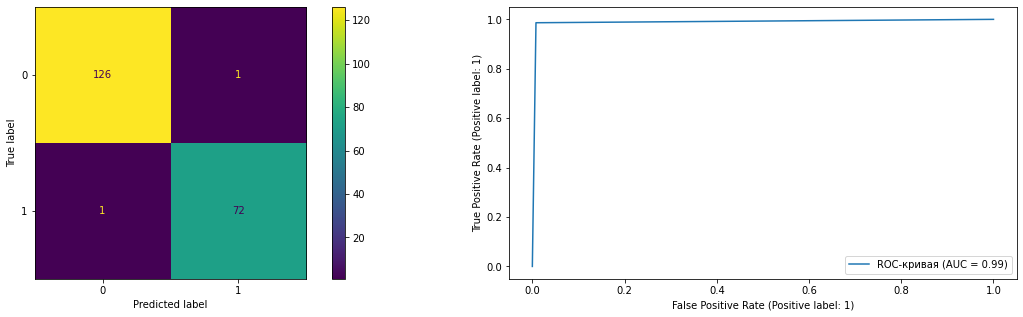

In [25]:
RFC_best = gscv4.best_estimator_
scores(RFC_best, test_X, test_y)

## Градиентный бустинг

[GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) из scikit-learn

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gscv5 = GridSearchCV(Pipeline([("gbc", GradientBoostingClassifier())]),
                    {"gbc__learning_rate" : [1e-1, 1e-2, 1e-3],
                     "gbc__n_estimators" : [50, 100]})
gscv5.fit(train_X, train_y)
best(gscv5)

Лучшие гиперпараметры модели: {'gbc__learning_rate': 0.01, 'gbc__n_estimators': 50}
Лучший счёт модели: 0.99125


Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


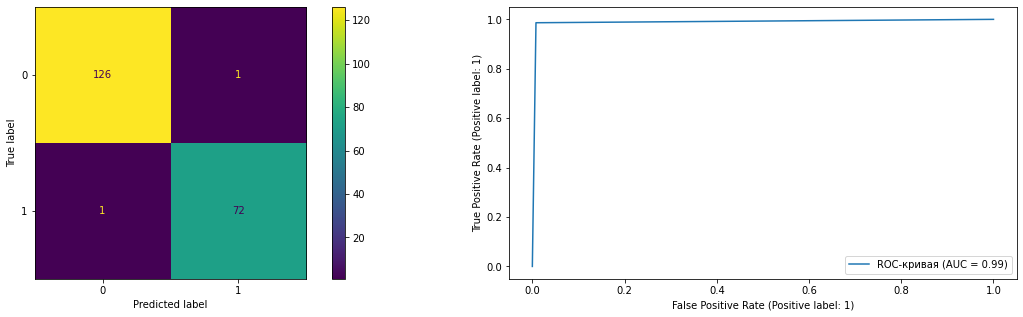

In [27]:
GBC_best = gscv5.best_estimator_
scores(GBC_best, test_X, test_y)

## Голосование

Для реализации жёсткого и мягкого голосований сделаю модели, которые возвращают вероятности

kNN из прошлой работы

In [28]:
from sklearn.metrics import euclidean_distances

class kNN_p(ClassifierMixin, BaseEstimator):
    def __init__(self, k = 1):
        self.k = k

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        
        p = np.ndarray((X.shape[0],))
        for (i, elem) in enumerate(X):
            distances = euclidean_distances([elem], self.X_)[0]
            neighbors = np.argpartition(distances, kth = self. k - 1)
            k_neighbors = neighbors[:self.k]
            labels = self.y_[k_neighbors]
            cnt = [0 for _ in range(2)]
            for elem in labels:
                cnt[elem] += 1
            p[i] = cnt[1] / (cnt[0] + cnt[1])
        return p

Логистическая регрессия из прошлой работы

In [29]:
class Net:
    def __init__(self, loss_function):
        self.layers = []
        self.loss = loss_function()
    
    def append(self, layer):
        self.layers.append(layer)
    
    # Вычисление предсказания
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, z):
        for layer in self.layers[::-1]:
            z = layer.backward(z)
        return z
    
    # Вычисление значения функции потерь
    def forward_loss(self, x, y):
        p = self.forward(x)
        return self.loss.forward(p, y)
    
    def backward_loss(self, l):
        dp = None
        dp = self.loss.backward(l)
        return self.backward(dp)
    
    def update(self, step):
        for layer in self.layers:
            if "update" in layer.__dir__():
                layer.update(step)
    
    # Эпоха обучения на данных x, y
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            loss = self.forward_loss(xb, yb)
            dx = self.backward_loss(loss)
            
            self.update(step)

In [30]:
class Linear:
    def __init__(self, n, m):
        mu = 0.0
        sigma = 1.0 / np.sqrt(2.0 * n)
        self.W = np.random.normal(mu, sigma, (m, n))
        self.b = np.zeros((1, m))
        self.dW = np.zeros((m, n))
        self.db = np.zeros((1, m))
    
    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W.T) + self.b
        return z

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self, step):
        self.W -= step * self.dW
        self.b -= step * self.db

In [31]:
class Sigmoid:
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y
    
    def backward(self, dy):
        return self.y * (1.0 - self.y) * dy

In [32]:
class BinaryCrossEntropy:
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)
    
    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]

In [33]:
class LogisticRegression_p(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.Net = Net(BinaryCrossEntropy)
        self.Net.append(Linear(8, 1))
        self.Net.append(Sigmoid())

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # Input validation
        X = check_array(X)
        
        n = X.shape[0]
        y = self.Net.forward(X).reshape((n,))
        return y
    
    def getW(self):
        return self.Net.layers[0].W
    
    def getb(self):
        return self.Net.layers[0].b

Метод опорных векторов с мягким зазором из прошлой работы

In [34]:
class SoftMarginSVM:
    def __init__(self, n, alpha):
        self.alpha = alpha
        mu = 0.0
        sigma = 1.0 / np.sqrt(n)
        self.W = np.random.normal(mu, sigma, (1, n + 1))
    
    def forward(self, x):
        z = np.dot(x, self.W.T)
        return z
    
    # Добавляет столбец из единиц
    def add_ones(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((x, ones))
    
    def predict(self, x):
        res = self.forward(self.add_ones(x))
        return 1.0 / (np.exp(-res) + 1.0)
    
    def train_epoch(self, x, y, batch_size = 100, step = 1e-7):
        x = self.add_ones(x)
        y = np.where(y > 0, 1, -1)
        for i in range(0, len(x), batch_size):
            xb = x[i:i + batch_size]
            yb = y[i:i + batch_size]

            pred = self.forward(xb)
            grad = self.alpha * self.W
            for i in range(len(xb)):
                if (yb[i] * pred[i] < 1):
                    grad -= yb[i] * xb[i]
            self.W -= step * grad

In [35]:
class SVM_p(ClassifierMixin, BaseEstimator):
    def __init__(self, epoches = 1, batch_size = 10, SGD_step = 0.001, alpha = 0.1):
        self.epoches = epoches
        self.batch_size = batch_size
        self.SGD_step = SGD_step
        self.alpha = alpha
        self.Net = SoftMarginSVM(8, alpha)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for _ in range(self.epoches):
            self.Net.train_epoch(X, y, self.batch_size, self.SGD_step)
        # Return the classifier
        return self

    def predict(self, X):
        y = self.Net.predict(X)
        return y.reshape((y.shape[0],))
    
    def getW(self):
        return self.Net.W

Наивный байесовский классификатор из прошлой работы

In [36]:
from math import pi

class NaiveBayes_p(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        self.X_ = X
        self.y_ = y
        
        labels, cnts = np.unique(self.y_, return_counts = True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis = 0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis = 0) for elem in labels])
        # Return the classifier
        return self

    def gaussian(self, mu, sigma, x0):
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * pi * sigma)
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array([self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = p[1] / np.sum(p)
        return res

Дерево принятия решений

In [37]:
class MyDecisionTreeClassifier_p(ClassifierMixin, BaseEstimator):
    def __init__(self, max_depth = 10, min_count = 50, rnd_split = False):
        self.max_depth = max_depth
        self.min_count = min_count
        self.rnd_split = rnd_split
        self.tree = DecisionTree(max_depth, min_count, rnd_split)

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        self.tree.build(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)
        
        p = []
        for elem in X:
            p.append(self.tree.decide(elem))
        return np.array(p)

Список моделей, выдающих вероятность класса

In [38]:
models = []
models.append(kNN_p(3))
models.append(LogisticRegression_p(SGD_step = 0.05, batch_size = 5, epoches = 2))
models.append(SVM_p(SGD_step =  0.01, alpha = 1.0, batch_size = 5, epoches = 4))
models.append(NaiveBayes_p())
models.append(MyDecisionTreeClassifier_p(max_depth = 2, min_count = 5))

## Мягкое голосование

In [39]:
class SVEnsemble(ClassifierMixin, BaseEstimator):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for model in self.models:
            model.fit(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        y, p = np.ndarray((X.shape[0],)), []
        for model in models:
            p.append(model.predict(X))
        p = np.array(p).T
        for i in range(len(X)):
            p_of_labels = np.array([0 for _ in range(2)])
            for j in range(len(models)):
                p1 = p[i][j]
                p0 = 1 - p1
                p_of_labels[0] += p0
                p_of_labels[1] += p1
            y[i] = p_of_labels.argmax()
        return y

Accuracy: 0.985
Recall: 0.9726027397260274
Precision: 0.9861111111111112


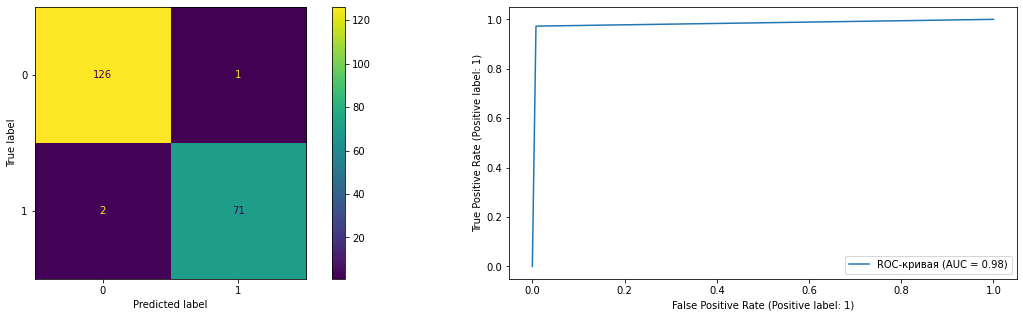

In [40]:
SVE = Pipeline([("SV", SVEnsemble(models))])
SVE.fit(train_X, train_y)
scores(SVE, test_X, test_y)

In [41]:
f = open("SVE.pkl", "wb")
pickle.dump(SVE, f, pickle.HIGHEST_PROTOCOL)
f.close()

## Жёсткое голосование

In [42]:
class HVEnsemble(ClassifierMixin, BaseEstimator):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        for model in self.models:
            model.fit(X, y)
        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X)

        y, p = np.ndarray((X.shape[0],)), []
        for model in models:
            p.append(model.predict(X))
        p = np.array(p).T
        for i in range(len(X)):
            cnt = np.array([0 for _ in range(2)])
            for j in range(len(models)):
                label = (1 if p[i][j] > 0.5 else 0)
                cnt[label] += 1
            y[i] = cnt.argmax()
        return y

Accuracy: 0.99
Recall: 0.9863013698630136
Precision: 0.9863013698630136


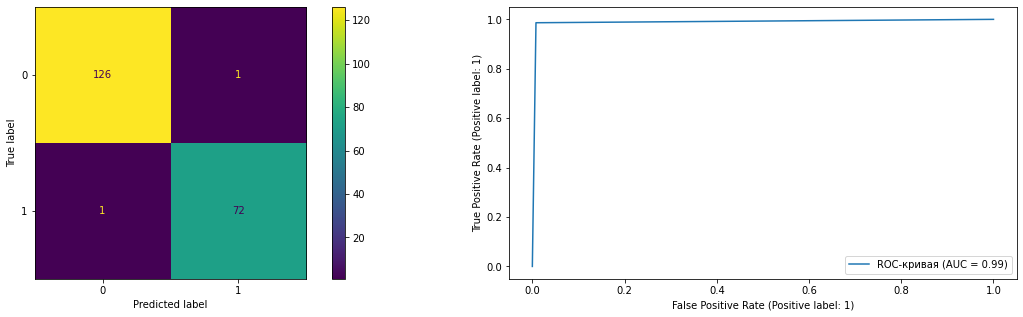

In [43]:
HVE = Pipeline([("HV", HVEnsemble(models))])
HVE.fit(train_X, train_y)
scores(HVE, test_X, test_y)

In [44]:
f = open("HVE.pkl", "wb")
pickle.dump(HVE, f, pickle.HIGHEST_PROTOCOL)
f.close()